In [1]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop,Adam
import os
import matplotlib.pyplot as pyplot
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


struktura folderów w google drive, żeby zaczytało dane

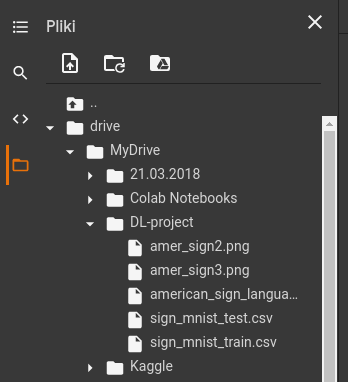

In [3]:
class Model():
  '''
  Each successive line contians 785 comma separated values between 0 and 255
  The first value is the label
  The rest are the pixel values for that picture
  The function, that will return 2 np.array types.
  One with all the labels and other with all the images
  '''

  def __init__(self):
    def get_data(filename):
      with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')    
        imgs = []
        labels = []

        next(reader, None)
        
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(float)
        labels = np.array(labels).astype(float)
      return images, labels


    self.training_images, self.training_labels = get_data("/content/drive/MyDrive/DL-project/sign_mnist_train.csv")
    self.testing_images, self.testing_labels = get_data("/content/drive/MyDrive/DL-project/sign_mnist_test.csv")

    print("Total Training images", self.training_images.shape)
    print("Total Training labels",self.training_labels.shape)
    print("Total Testing images",self.testing_images.shape)
    print("Total Testing labels",self.testing_labels.shape)

    #Data Augmentation
    self.training_images = np.expand_dims(self.training_images, axis = 3)
    self.testing_images = np.expand_dims(self.testing_images, axis = 3)

    # Create an ImageDataGenerator and do Image Augmentation
    self.train_datagen = ImageDataGenerator(
      rescale=1. / 255, #rescaling factor
      rotation_range=40, #degree range for random rotations
      width_shift_range=0.2, #
      height_shift_range=0.2, #
      shear_range=0.2,  #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
      zoom_range=0.2,   #Float or [lower, upper]. Range for random zoom. 
      horizontal_flip=True, #Randomly flip inputs horizontally.
      fill_mode='nearest' #Randomly flip inputs vertically
      )

    self.validation_datagen = ImageDataGenerator(rescale=1. / 255 )

    self.train_gen = self.train_datagen.flow(
      self.training_images,
      self.training_labels,
      batch_size=64
    )

    self.val_gen = self.validation_datagen.flow(
      self.testing_images,
      self.testing_labels,
      batch_size=64
    )
  

  def show_images(self):
    for i in range(0, 9):
      pyplot.subplot(330 + 1 + i)
      img=self.training_images[i][:].reshape(28,28)
      pyplot.imshow(img)
      pyplot.title("Sign " + str(self.training_labels[i]))
      pyplot.axis('off')
	# show the plot
    plt.suptitle("Before Augmentation") 
    pyplot.show()

    for i in range(0, 9):
      show=self.train_gen.next()
      pyplot.subplot(3,3,i+1)
      pyplot.imshow(show[0][i].reshape(28, 28))
      pyplot.title("Sign " + str(show[1][i]))
      pyplot.axis('off')
	# show the plot
    plt.suptitle("After Augmentation") 
    pyplot.show()

  #function for creating model with some hiperparametrs
  def create_model(self):
    self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation = 'relu'),
            tf.keras.layers.Dense(25, activation = "softmax")
        ])
      
# Define the optimizer
    self.optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    self.model.compile(optimizer=self.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Compile Model. As this is multi class classification, keep loss as categorical
        
    tf.keras.utils.plot_model(
    self.model,
    to_file="/content/drive/MyDrive/DL-project/best_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    )

  def train_model(self):
    checkpoint_filepath = '"/content/drive/MyDrive/DL-project/best_model.hdf5'

    callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
    callback_learningrate = ReduceLROnPlateau(monitor='loss', mode='min', min_delta=0.01, patience=3, factor=.75, min_lr=0.00001, verbose=1)
    early_stop=EarlyStopping(monitor='val_loss',min_delta=0.001,patience=10)
  
    self.history = self.model.fit_generator(self.train_gen,
                              epochs = 50, 
                              validation_data=self.val_gen,
                             callbacks=[callback_checkpoint, callback_learningrate, early_stop])
  
    self.model.evaluate(self.testing_images, self.testing_labels, verbose=0)

    model_json = self.model.to_json()
    with open("/content/drive/MyDrive/DL-project/best_model1.json", "w") as json_file:
      json_file.write(model_json)
      # serialize weights to HDF5
    self.model.save_weights("/content/drive/MyDrive/DL-project/best_model1.h5")
    print("Saved model to disk")

  #function which plots accuracy and loss
  def draw_results(self):
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.title("model accuracy train/validation")
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.subplot(2,1,2)
    plt.title("model loss train/validation")
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout()
    return fig

  #function which allows to check classification report and confusion matrix
  def show_metrics(self):   
    #predict the label of the test_images
    y_pred = self.model.predict(self.testing_images)
    y_pred = np.argmax(y_pred, axis=1) 
    #create classification report
    cl_report = classification_report(self.testing_labels, y_pred)
    #create confusion matrix
    c_m = confusion_matrix(self.testing_labels, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = c_m, figsize=(10 , 10), cmap=plt.cm.Greens)
    plt.ylabel('Actuals',fontsize = 12)
    plt.xlabel('Predictions',fontsize = 12)
    plt.title('Confusion Matrix',fontsize = 16) 
    plt.show()
    return print(cl_report)
  
  #function which show predicted class for a picture
  def predict_sign(self, img_name):
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dsize = (28, 28)
    output = cv2.resize(img_gray, dsize)
    img_conv = output.reshape([-1,28,28,1])
    img_conv = img_conv/255.0
    y_pred = self.model.predict_classes(img_conv)
    plt.imshow(output)
    plt.title("Picture of sign to be predicted")
    plt.show()
    img_train=self.training_images[y_pred][:].reshape(28,28)
    pyplot.imshow(img_train)
    pyplot.title("Picture of predicted sign")
    plt.show()
    return print('Predicted class is: ' + str(y_pred))

  def predict_sign2(self, img_name):
    alphabets = 'abcdefghijklmnopqrstuvwxyz'
    mapping_letter = {}
    for i,l in enumerate(alphabets):
      mapping_letter[l] = i
    mapping_letter = {v:k for k,v in mapping_letter.items()}  
    text = img_name.split('.',1)
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dsize = (28, 28)
    output = cv2.resize(img_gray, dsize)
    img_conv = output.reshape([-1,28,28,1])
    img_conv = img_conv/255.0
    pred = self.model.predict(img_conv)
    pred = np.argmax(pred,axis=1)
    return print('Predicted sign:',mapping_letter[pred[0]])

In [4]:
model=Model()

Total Training images (27455, 28, 28)
Total Training labels (27455,)
Total Testing images (7172, 28, 28)
Total Testing labels (7172,)


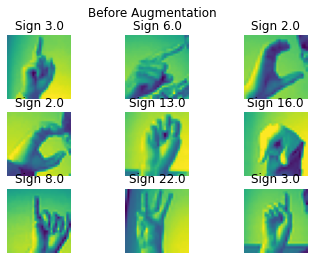

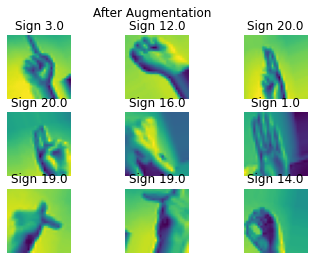

In [5]:
model.show_images()

In [6]:
model.create_model()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
model.train_model()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
429/429 [==============================] - 41s 23ms/step - loss: 2.9454 - accuracy: 0.1151 - val_loss: 2.3248 - val_accuracy: 0.2543
Epoch 2/50
429/429 [==============================] - 9s 22ms/step - loss: 2.3074 - accuracy: 0.2793 - val_loss: 1.8954 - val_accuracy: 0.3568
Epoch 3/50
429/429 [==============================] - 9s 20ms/step - loss: 1.9089 - accuracy: 0.3961 - val_loss: 1.3598 - val_accuracy: 0.5368
Epoch 4/50
429/429 [==============================] - 8s 20ms/step - loss: 1.6211 - accuracy: 0.4736 - val_loss: 1.1318 - val_accuracy: 0.5943
Epoch 5/50
429/429 [==============================] - 8s 20ms/step - loss: 1.4188 - accuracy: 0.5384 - val_loss: 1.0027 - val_accuracy: 0.6514
Epoch 6/50
429/429 [==============================] - 8s 20ms/step - loss: 1.2747 - accuracy: 0.5763 - val_loss: 0.8433 - val_accuracy: 0.7004
Epoch 7/50
429/429 [==============================] - 9s 20ms/step - loss: 1.1532 - accuracy: 0.6174 - val_loss: 0.7513 - val_accuracy: 0.749

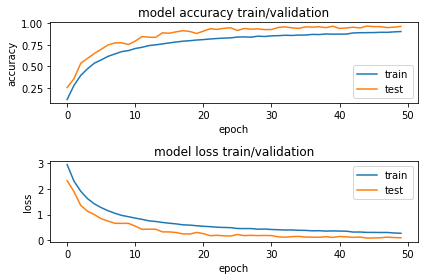

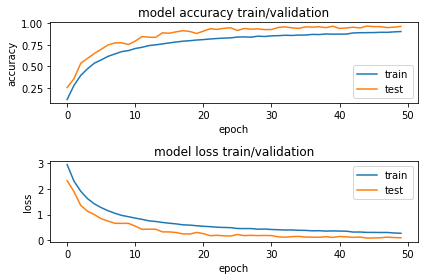

In [8]:
model.draw_results()

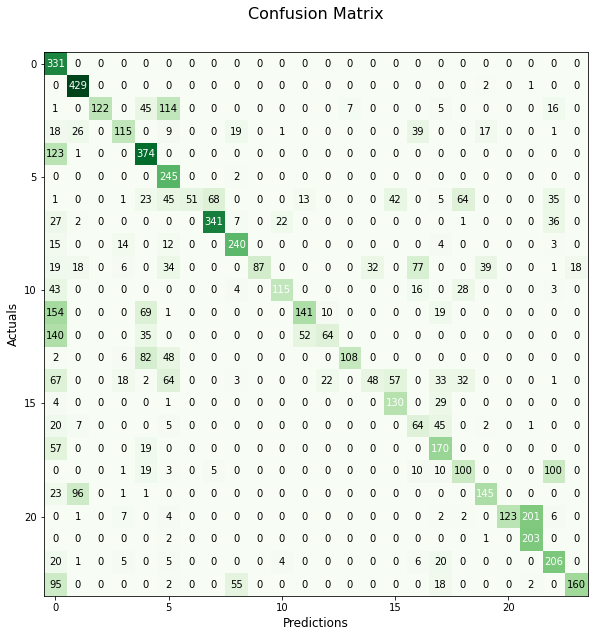

              precision    recall  f1-score   support

         0.0       0.29      1.00      0.44       331
         1.0       0.74      0.99      0.85       432
         2.0       1.00      0.39      0.56       310
         3.0       0.66      0.47      0.55       245
         4.0       0.56      0.75      0.64       498
         5.0       0.41      0.99      0.58       247
         6.0       1.00      0.15      0.26       348
         7.0       0.82      0.78      0.80       436
         8.0       0.73      0.83      0.78       288
        10.0       1.00      0.26      0.42       331
        11.0       0.81      0.55      0.66       209
        12.0       0.68      0.36      0.47       394
        13.0       0.67      0.22      0.33       291
        14.0       0.94      0.44      0.60       246
        15.0       0.60      0.14      0.22       347
        16.0       0.57      0.79      0.66       164
        17.0       0.30      0.44      0.36       144
        18.0       0.47    

In [9]:
model.show_metrics()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


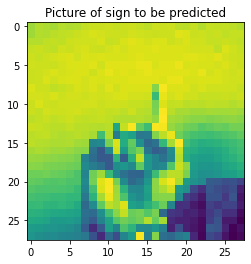

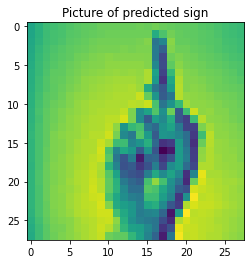

Predicted class is: [24]


In [10]:
model.predict_sign("/content/drive/MyDrive/DL-project/sign_check.JPG")

In [11]:
model.predict_sign2("/content/drive/MyDrive/DL-project/sign_check.JPG")

Predicted sign: y
